<a href="https://colab.research.google.com/github/myazdani/gan-toy-datasets/blob/main/score-matching-swiss-roll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Ref](https://github.com/acids-ircam/diffusion_models/blob/main/diffusion_01_score.ipynb)


- How can we estimate $p(\mathbf{x})$?
- Instead of learning $p(\mathbf{x})$, we rather aim to learn the gradients $\nabla_{\mathbf{x}} \log p(\mathbf{x})$ 
- the gradients $\nabla_{\mathbf{x}} \log p(\mathbf{x})$ are termed the _score_ of the density $p(\mathbf{x})$
- Let's train a network $\mathcal{F}_{\theta}(\mathbf{x})$ with a  loss function looks that matches the score:
$$ \mathcal{L}_{mse} = E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\lVert \mathcal{F}_{\theta}(\mathbf{x}) - \nabla_{\mathbf{x}} \log p(\mathbf{x}) \right\lVert_2^2 \right] $$
- This is just a regression loss but the challenge is the target function $\nabla_{\mathbf{x}} \log p(\mathbf{x})$  is unkonwn
- It turns out through some math magic we can re-write thie regression fucntion like this:

$$ \mathcal{L}_{matching} = E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})  \right) + \frac{1}{2} \left\Vert \mathcal{F}_{\theta}(\mathbf{x}) \right\lVert_2^2 \right]
, $$

- where $\nabla_{\mathbf{x}} \mathcal{F}_{\theta}(\mathbf{x})$ denotes the Jacobian of $\mathcal{F}_{\theta}(\mathbf{x})$ with respect to $\mathbf{x}$, and $ \text{tr}(\cdot) $ is the _trace_ operation. Proof given in the appendix [here](https://www.jmlr.org/papers/volume6/hyvarinen05a/hyvarinen05a.pdf)
- OK, so now we have to compute two things:
  - the norm of the model output $\frac{1}{2} \left\Vert \mathcal{F}_{\theta}(\mathbf{x}) \right\lVert_2^2$
  - the trace of the Jacobian loss $\text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x}) \right)$

That Jacobian term is gonna be expensive but let's roll with it!  

In [1]:
!pip uninstall -y torch

Found existing installation: torch 1.12.1+cu113
Uninstalling torch-1.12.1+cu113:
  Successfully uninstalled torch-1.12.1+cu113


In [2]:
!pip install --pre torch -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html
     |████████████████████████████████| 198.0 MB 58 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.14.0.dev20221122+cpu which is incompatible.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.14.0.dev20221122+cpu which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.14.0.dev20221122+cpu which is incompatible.
fastai 2.7.10 requires torch<1.14,>=1.7, but you have torch 1.14.0.dev20221122+cpu which is incompatible.


#### generate some toy data

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll

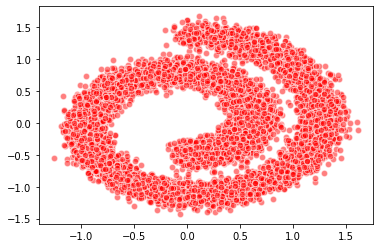

In [4]:
# Sample a batch from the swiss roll
def sample_batch(size, noise=1.0):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0

data = sample_batch(10**4).T
plt.scatter(*data, alpha=0.5, color='red', edgecolor='white', s=40);

#### model architecture

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
# Our approximation model
model = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(), # smooth relu
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
)
# Create ADAM optimizer over our model
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#### jacobian

In [6]:
import torch.autograd as autograd
from functorch import vmap, jacrev, jacfwd

def manual_jacobian(f, x):
    """Computes the Jacobian of f w.r.t x.
    :param f: function R^N -> R^N
    :param x: torch.tensor of shape [B, N]
    :return: Jacobian matrix (torch.tensor) of shape [B, N, N]
    """
    B, N = x.shape
    y = f(x)
    jacobian = list()
    for i in range(N):
        v = torch.zeros_like(y)
        v[:, i] = 1.
        dy_i_dx = autograd.grad(y, x, grad_outputs=v, retain_graph=True, create_graph=True, allow_unused=True)[0]  # shape [B, N]
        jacobian.append(dy_i_dx)
    jacobian = torch.stack(jacobian, dim=2).requires_grad_()
    return jacobian


def functorch_jacobian(f, x):
    jacobian = vmap(jacrev(f))(x)
    #jacobian = vmap(jacfwd(f))(x)
    return jacobian


#### score matching loss

In [7]:
def score_matching(model, samples, train=False, use_functorch=False):
    samples.requires_grad_(True)
    logp = model(samples)
    # Compute the norm loss
    norm_loss = torch.norm(logp, dim=-1) ** 2 / 2.
    # Compute the Jacobian loss
    if use_functorch:
        jacob_mat = functorch_jacobian(model, samples)
    else:
        jacob_mat = manual_jacobian(model, samples)
    tr_jacobian_loss = torch.diagonal(jacob_mat, dim1=-2, dim2=-1).sum(-1)
    return (tr_jacobian_loss + norm_loss).mean(-1)

#### training

In [8]:
%%time
dataset = torch.tensor(data.T).float()[:32,:]
for t in range(1000):
    # Compute the loss.
    loss = score_matching(model, dataset, use_functorch=False)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    if ((t % 100) == 0):
        print(loss)

tensor(-0.0190, grad_fn=<MeanBackward1>)
tensor(-2.4624, grad_fn=<MeanBackward1>)
tensor(-7.0394, grad_fn=<MeanBackward1>)
tensor(-25.4593, grad_fn=<MeanBackward1>)
tensor(-55.4370, grad_fn=<MeanBackward1>)
tensor(-150.0622, grad_fn=<MeanBackward1>)
tensor(-310.6929, grad_fn=<MeanBackward1>)
tensor(-491.8479, grad_fn=<MeanBackward1>)
tensor(-709.8077, grad_fn=<MeanBackward1>)
tensor(-967.3587, grad_fn=<MeanBackward1>)
CPU times: user 2.95 s, sys: 12.3 ms, total: 2.97 s
Wall time: 2.98 s


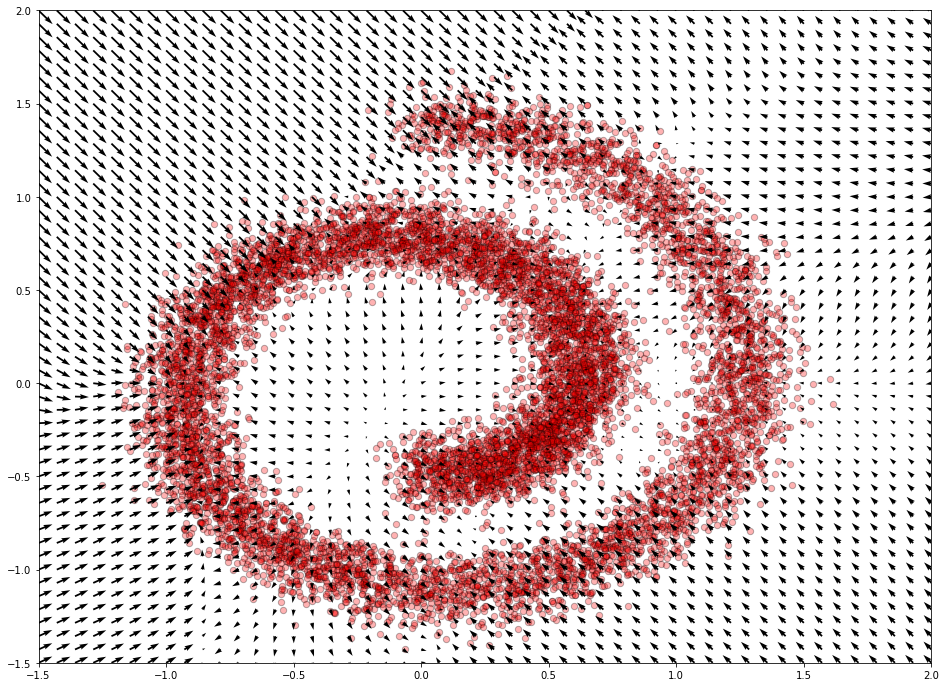

In [9]:
def plot_gradients(model, data, plot_scatter=True):
    xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 50), np.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
    scores = model(torch.tensor(xx).float()).detach()
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
    # Perform the plots
    plt.figure(figsize=(16,12))
    if (plot_scatter):
        plt.scatter(*data, alpha=0.3, color='red', edgecolor='black', s=40)
    plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='black')
    plt.xlim(-1.5, 2.0)
    plt.ylim(-1.5, 2.0)
plot_gradients(model, data)

## OK we got the gradients, but how do we generate smaples? Langevin dynamics

Since we now have a function that approximates the gradient of the density pretty well, ie $\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_x \log p(x)$, we can start with an initial random sample and then use our approximation to update the sample. 

So we could do something like pick $\mathbf{x}_{0} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$, and then iteratively update the sample with gradient ascent in small steps $\epsilon$:

$$\mathbf{x}_{t + 1} = \mathbf{x}_t + \epsilon \nabla_{\mathbf{x}_t} log p(\mathbf{x}_t)$$

But it turns out these samples are not true to $\mathbf{x} \sim p(\mathbf{x})$. It turns out Langevin dynamics where a little bit of white noise is added to gradient ascent/descnt does the trick (as shown by [Welling et al. (2011)](https://www.ics.uci.edu/~welling/publications/papers/stoclangevin_v6.pdf):

$$\mathbf{x}_{t + 1} = \mathbf{x}_t + \frac{\epsilon}{2} \nabla_{\mathbf{x}_t} log p(\mathbf{x}_t) + \sqrt{\epsilon} \mathbf{z}_{t}$$

where $\mathbf{z}_{t}\sim \mathcal{N}(\mathbf{0},\mathbf{I})$. Below we can now see what these samples look like:

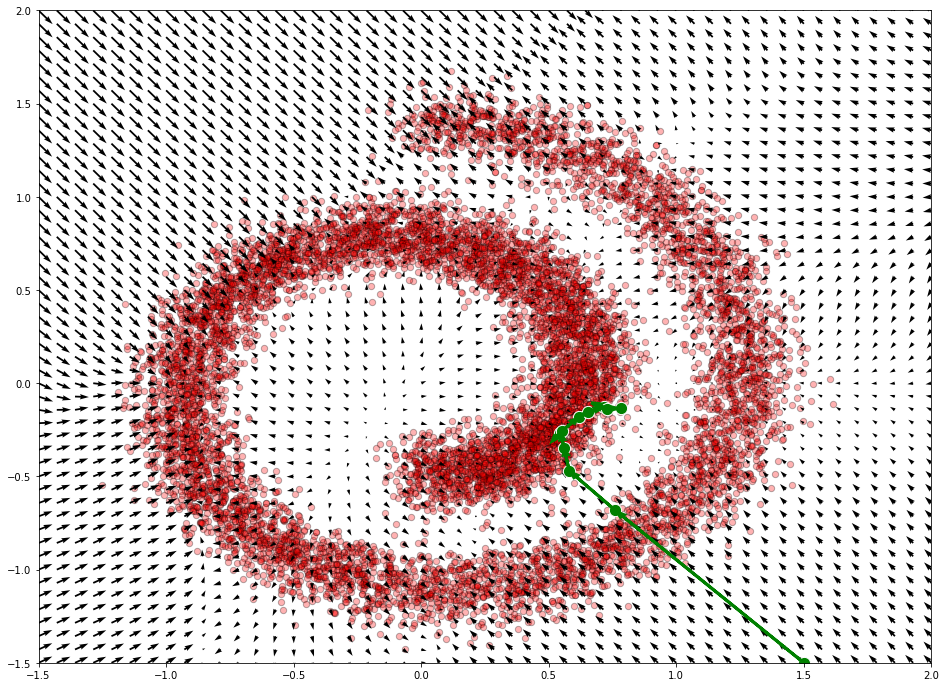

In [10]:
def sample_langevin(model, x, n_steps=10, eps=1e-2, decay=.9, temperature=1.0):
    x_sequence = [x.unsqueeze(0)]
    for s in range(n_steps):
        z_t = torch.rand(x.size())
        x = x + (eps / 2) * model(x) + (np.sqrt(eps) * temperature * z_t)
        x_sequence.append(x.unsqueeze(0))
        eps *= decay
    return torch.cat(x_sequence)

x = torch.Tensor([1.5, -1.5])
samples = sample_langevin(model, x).detach()
plot_gradients(model, data)
plt.scatter(samples[:, 0], samples[:, 1], color='green', edgecolor='white', s=150)
# draw arrows for each mcmc step
deltas = (samples[1:] - samples[:-1])
deltas = deltas - deltas / np.linalg.norm(deltas, keepdims=True, axis=-1) * 0.04
for i, arrow in enumerate(deltas):
    plt.arrow(samples[i,0], samples[i,1], arrow[0], arrow[1], width=1e-4, head_width=2e-2, color="green", linewidth=3)

## Jacobians are expensive. Taking random projections of it should make things faster. 

In [11]:
def sliced_score_matching(model, samples):
    samples.requires_grad_(True)
    # Construct random vectors
    vectors = torch.randn_like(samples)
    vectors = vectors / torch.norm(vectors, dim=-1, keepdim=True)
    # Compute the optimized vector-product jacobian
    logp, jvp = autograd.functional.jvp(model, samples, vectors, create_graph=True)
    # Compute the norm loss
    norm_loss = (logp * vectors) ** 2 / 2.
    # Compute the Jacobian loss
    v_jvp = jvp * vectors
    jacob_loss = v_jvp
    loss = jacob_loss + norm_loss
    return loss.mean(-1).mean(-1)

In [12]:
# Our approximation model
model = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
)
# Create ADAM optimizer over our model
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T)[:1000].float()


In [13]:
%%time
for t in range(2000):
    # Compute the loss.
    loss = sliced_score_matching(model, dataset)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    # Print loss
    if ((t % 500) == 0):
        print(loss)

tensor(0.0071, grad_fn=<MeanBackward1>)
tensor(-0.9143, grad_fn=<MeanBackward1>)
tensor(-6.0748, grad_fn=<MeanBackward1>)
tensor(-7.9070, grad_fn=<MeanBackward1>)
CPU times: user 36.2 s, sys: 1.21 s, total: 37.4 s
Wall time: 37.8 s


## Denoising score matching

- Consider what happens when we add a little white noise to corrupt $\mathbf{x}$
$$
\tilde{\mathbf{x}} = \mathbf{x}  + \epsilon 
$$
where $\epsilon \sim \mathcal{N}(0, \sigma^{2}\mathbf{I})$. 
- We can also write this in a slighlty different notation as:
$$
\tilde{\mathbf{x}}\sim q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})=\mathcal{N}(\tilde{\mathbf{x}}\mid\mathbf{x}, \sigma^{2}\mathbf{I})
$$
where we are saying that $\tilde{\mathbf{x}}$ is a realization from a normal distribution with mean $\mathbf{x}$ and variance $\sigma^{2}\mathbf{I}$.
- then we have $\nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x}) = -\frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^{2}}$
- If the noise corruption, ie $\sigma$ is small, then $\mathcal{F}_{\theta}(\mathbf{x}) = \nabla_{\mathbf{x}} \log q_{\sigma}(\mathbf{x}) \approx \nabla_{\mathbf{x}} \log p(\mathbf{x})$ 
- Therefore, the denoising score matching loss simply becomes

$$ \mathcal{l}(\theta;\sigma) = E_{q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\Vert \mathcal{F}_{\theta}(\tilde{\mathbf{x}}) +  \frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^{2}} \right\lVert_2^2 \right]
, $$

In [38]:
def denoising_score_matching(scorenet, samples, sigma=0.01):
    perturbed_samples = samples + torch.randn_like(samples) * sigma
    target = - 1 / (sigma ** 2) * (perturbed_samples - samples)
    scores = scorenet(samples)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1).mean(dim=0)
    return loss

In [39]:
# Our approximation model
model = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
)
# Create ADAM optimizer over our model
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()


In [40]:
%%time
for t in range(5000):
    # Compute the loss.
    loss = denoising_score_matching(model, dataset)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    # Print loss
    if ((t % 1000) == 0):
        print(loss)

tensor(9993.7832, grad_fn=<MulBackward0>)
tensor(9974.3896, grad_fn=<MulBackward0>)
tensor(9957.6221, grad_fn=<MulBackward0>)
tensor(10083.6973, grad_fn=<MulBackward0>)
tensor(10135.6455, grad_fn=<MulBackward0>)
CPU times: user 4min 9s, sys: 5.71 s, total: 4min 15s
Wall time: 4min 14s


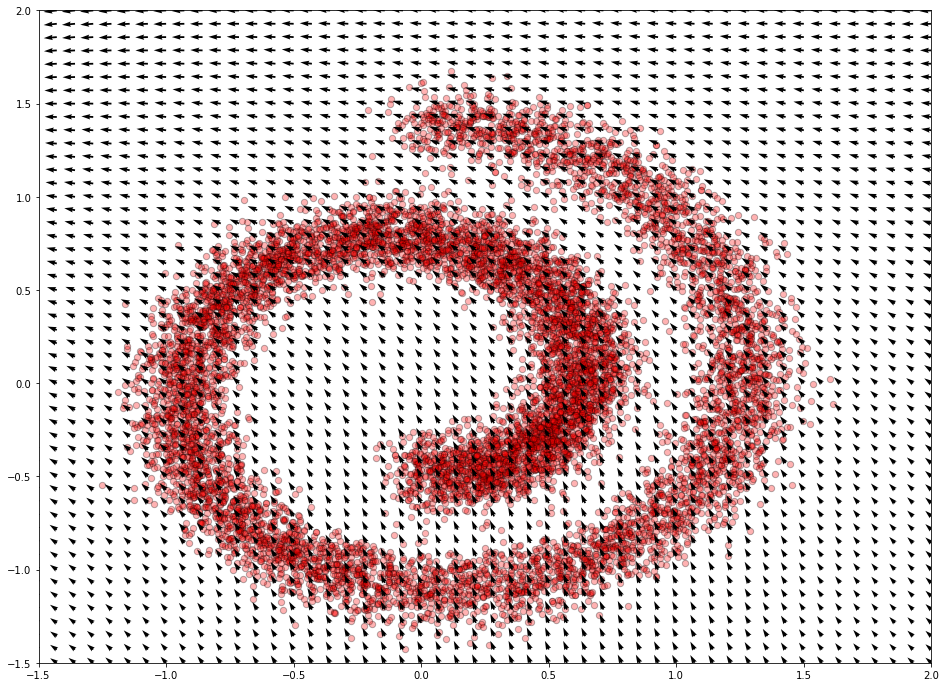

In [41]:
plot_gradients(model, data)